# Extração de descritores de imagens digitais

Código desenvolvido por Ian Marques Breda e Kaio Henrique Avelino Domeni de Paulo, cujo objetivo é extrair descritores de imagens digitais e plotar gráficos 3D usando os descritores como eixos para determinar os melhores para a diferenciação das imagens analisadas.

### Bibliotecas utilizadas

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.feature import local_binary_pattern
from skimage.feature.texture import graycomatrix, graycoprops
from sklearn.linear_model import LinearRegression

### Constantes

In [11]:
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = 'uniform'
GLCM_DIST = 1
GLCM_ANGLE = 0

## Funções auxiliares

### Cálculo de Haralick - SMA, entropia e constraste

In [3]:
def calcular_haralick(image):
    glcm = graycomatrix(image, distances=[GLCM_DIST], angles=[GLCM_ANGLE], levels=256, symmetric=True, normed=True)
    asm = graycoprops(glcm, 'energy')[0, 0]
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    glcm_p = glcm[:, :, 0, 0]
    entropia = -np.sum(glcm_p * np.log2(glcm_p + 1e-10))
    return asm, entropia, contrast

### Local Binary Patterns

In [4]:
def calcular_lbp(image):
    lbp = local_binary_pattern(image, P=LBP_POINTS, R=LBP_RADIUS, method=LBP_METHOD)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), range=(0, LBP_POINTS + 2))
    hist = hist.astype("float") / (hist.sum() + 1e-6)
    return hist.mean()

### Dimensão fractal

In [5]:
def box_count(img, box_size):
    h, w = img.shape
    S = 0
    for y in range(0, h, box_size):
        for x in range(0, w, box_size):
            if np.any(img[y:y+box_size, x:x+box_size]):
                S += 1
    return S

def calcular_dimensao_fractal(image, max_iter=6):
    image = (image > 0).astype(np.uint8)  # binarização para box-counting
    sizes = [2**i for i in range(1, max_iter + 1)]
    counts = []

    for size in sizes:
        count = box_count(image, size)
        counts.append(count)

    log_sizes = np.log(sizes)
    log_counts = np.log(counts)

    model = LinearRegression()
    model.fit(log_sizes.reshape(-1, 1), log_counts)
    df_total = model.coef_[0]
    return df_total, log_counts[0], log_counts[1]  # valores das iterações 1 e 2

### Processamento da imagem

In [6]:
def processar_imagem(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    asm, entropia, contraste = calcular_haralick(img)
    lbp_val = calcular_lbp(img)
    df_total, df_it1, df_it2 = calcular_dimensao_fractal(img)
    return [asm, entropia, contraste, lbp_val, df_total, df_it1, df_it2]

### Processa o diretório de imagens

In [7]:
def processar_diretorio(diretorio):
    vetores = []
    nomes = []
    for nome_arquivo in os.listdir(diretorio):
        if nome_arquivo.lower().endswith(('.png', '.jpg', '.bmp', '.tif')):
            caminho = os.path.join(diretorio, nome_arquivo)
            vetor = processar_imagem(caminho)
            vetores.append(vetor)
            nomes.append(nome_arquivo)
            print(f"{nome_arquivo} -> {vetor}")
    return nomes, np.array(vetores)

### Visualização 3D

In [8]:
def plotar_3d(vetores, nomes, indices, titulo, eixos):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(projection='3d')
    ax.set_title(titulo, fontdict={'fontsize': 30})
    ax.set_xlabel(eixos[0], fontdict={'fontsize': 30}, labelpad=20)
    ax.set_ylabel(eixos[1], fontdict={'fontsize': 30}, labelpad=20)
    ax.set_zlabel(eixos[2], fontdict={'fontsize': 30}, labelpad=10)

    for i, nome in enumerate(nomes):
        ax.scatter(vetores[i, indices[0]], vetores[i, indices[1]], vetores[i, indices[2]], s=250, label=nome, )
    ax.legend()
    plt.legend(loc=1, prop={'size': 20})
    plt.show()

## Execução

R0_caso1.JPG -> [np.float64(0.0402350792409944), np.float64(12.724452692939362), np.float64(188.13380267000417), np.float64(0.09999999999979167), np.float64(-1.9764314298405694), np.float64(11.695247021764184), np.float64(10.308952660644293)]
R0_caso2.JPG -> [np.float64(0.057969851473447874), np.float64(12.061122765873055), np.float64(199.03406967042136), np.float64(0.09999999999979167), np.float64(-1.9764314298405694), np.float64(11.695247021764184), np.float64(10.308952660644293)]
R3_caso1.JPG -> [np.float64(0.017558335746241393), np.float64(13.401420020730548), np.float64(419.213535669587), np.float64(0.09999999999979167), np.float64(-1.976429712339317), np.float64(11.695238688396127), np.float64(10.308952660644293)]
R3_caso2.JPG -> [np.float64(0.029148936841941215), np.float64(13.868500519285629), np.float64(897.3554109303295), np.float64(0.09999999999979167), np.float64(-1.9764039481028723), np.float64(11.695113679541171), np.float64(10.308952660644293)]


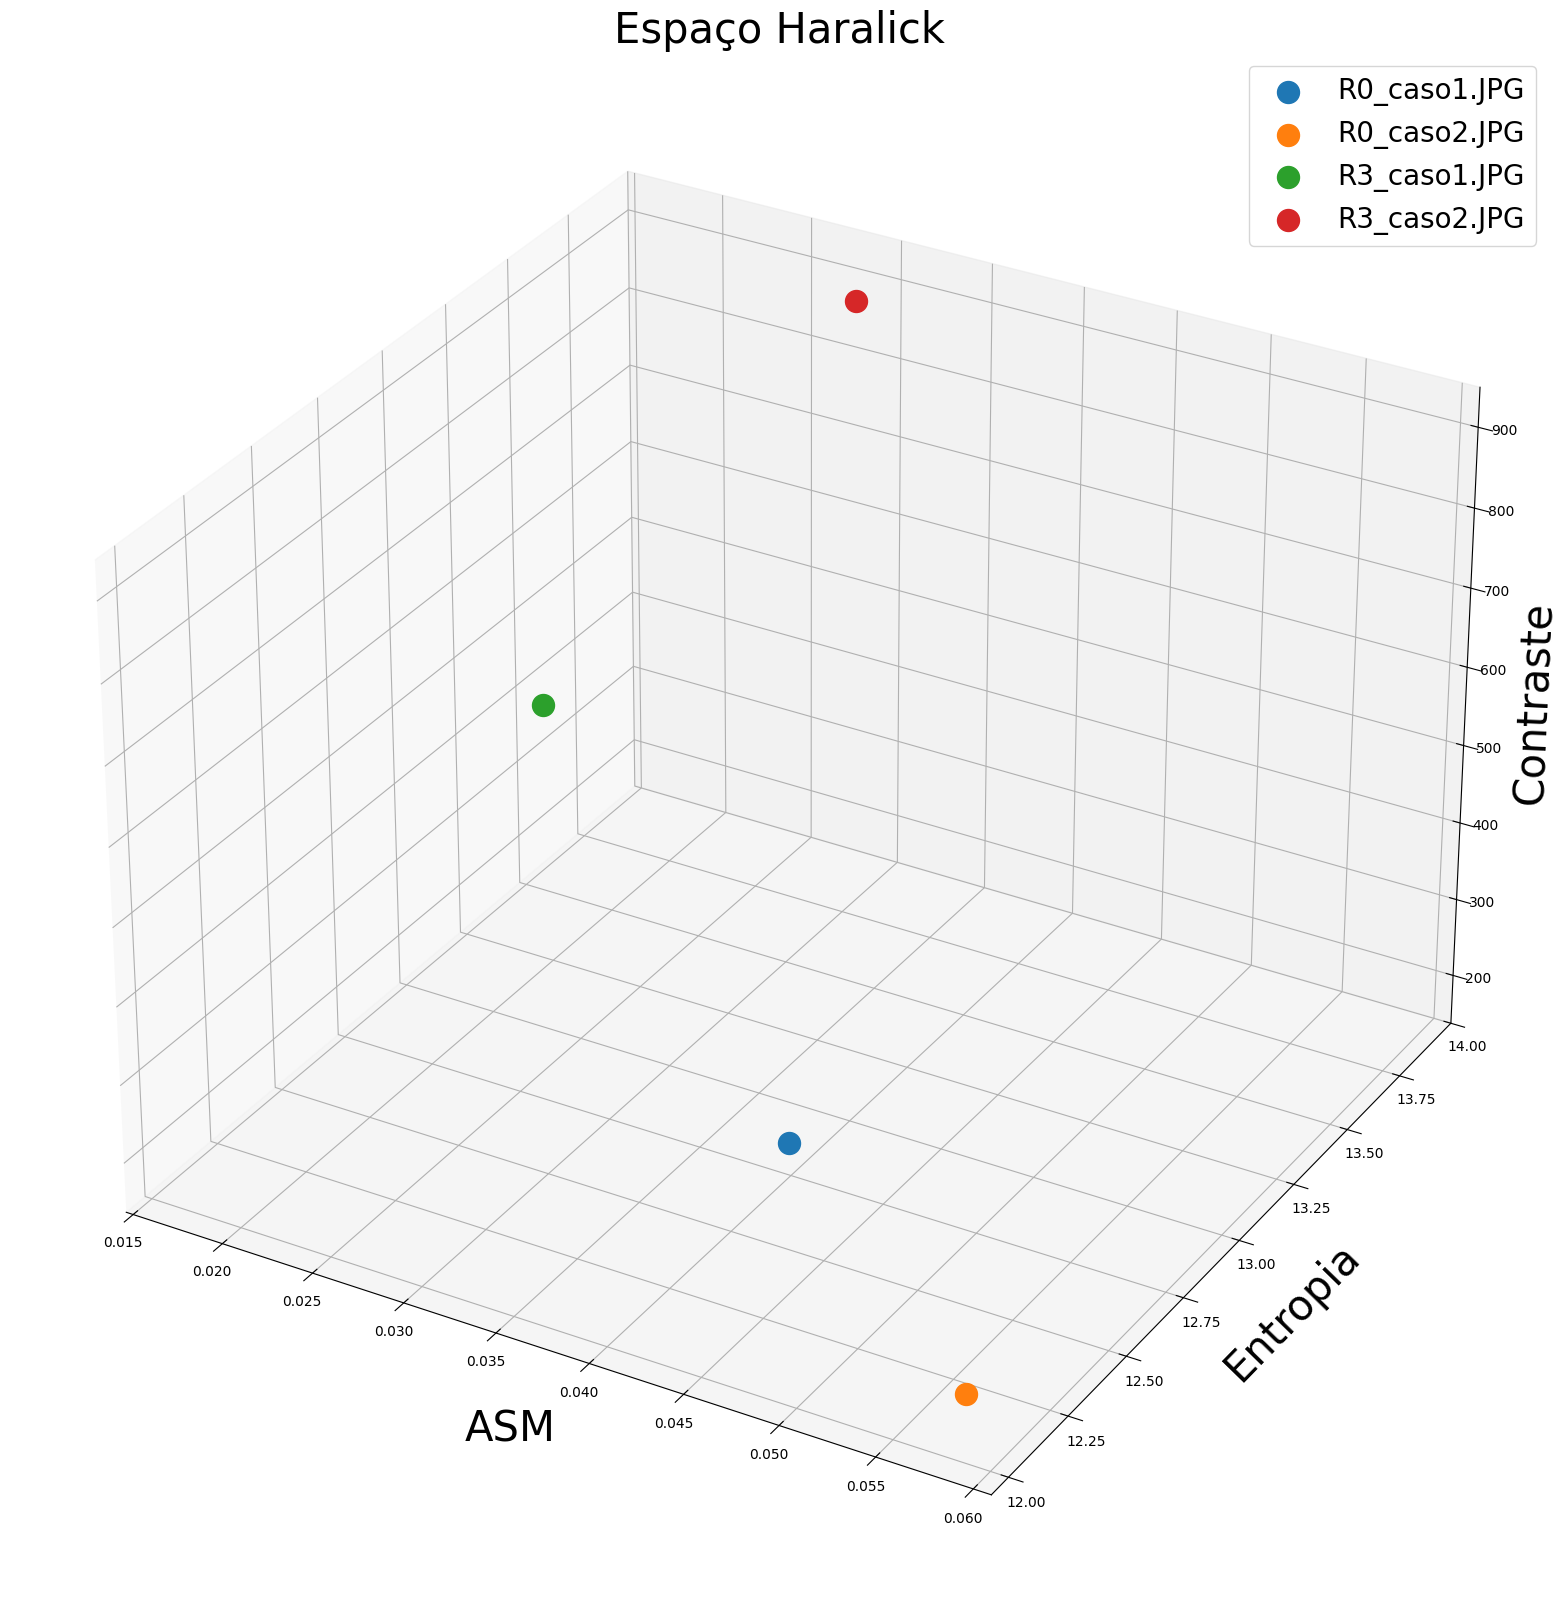

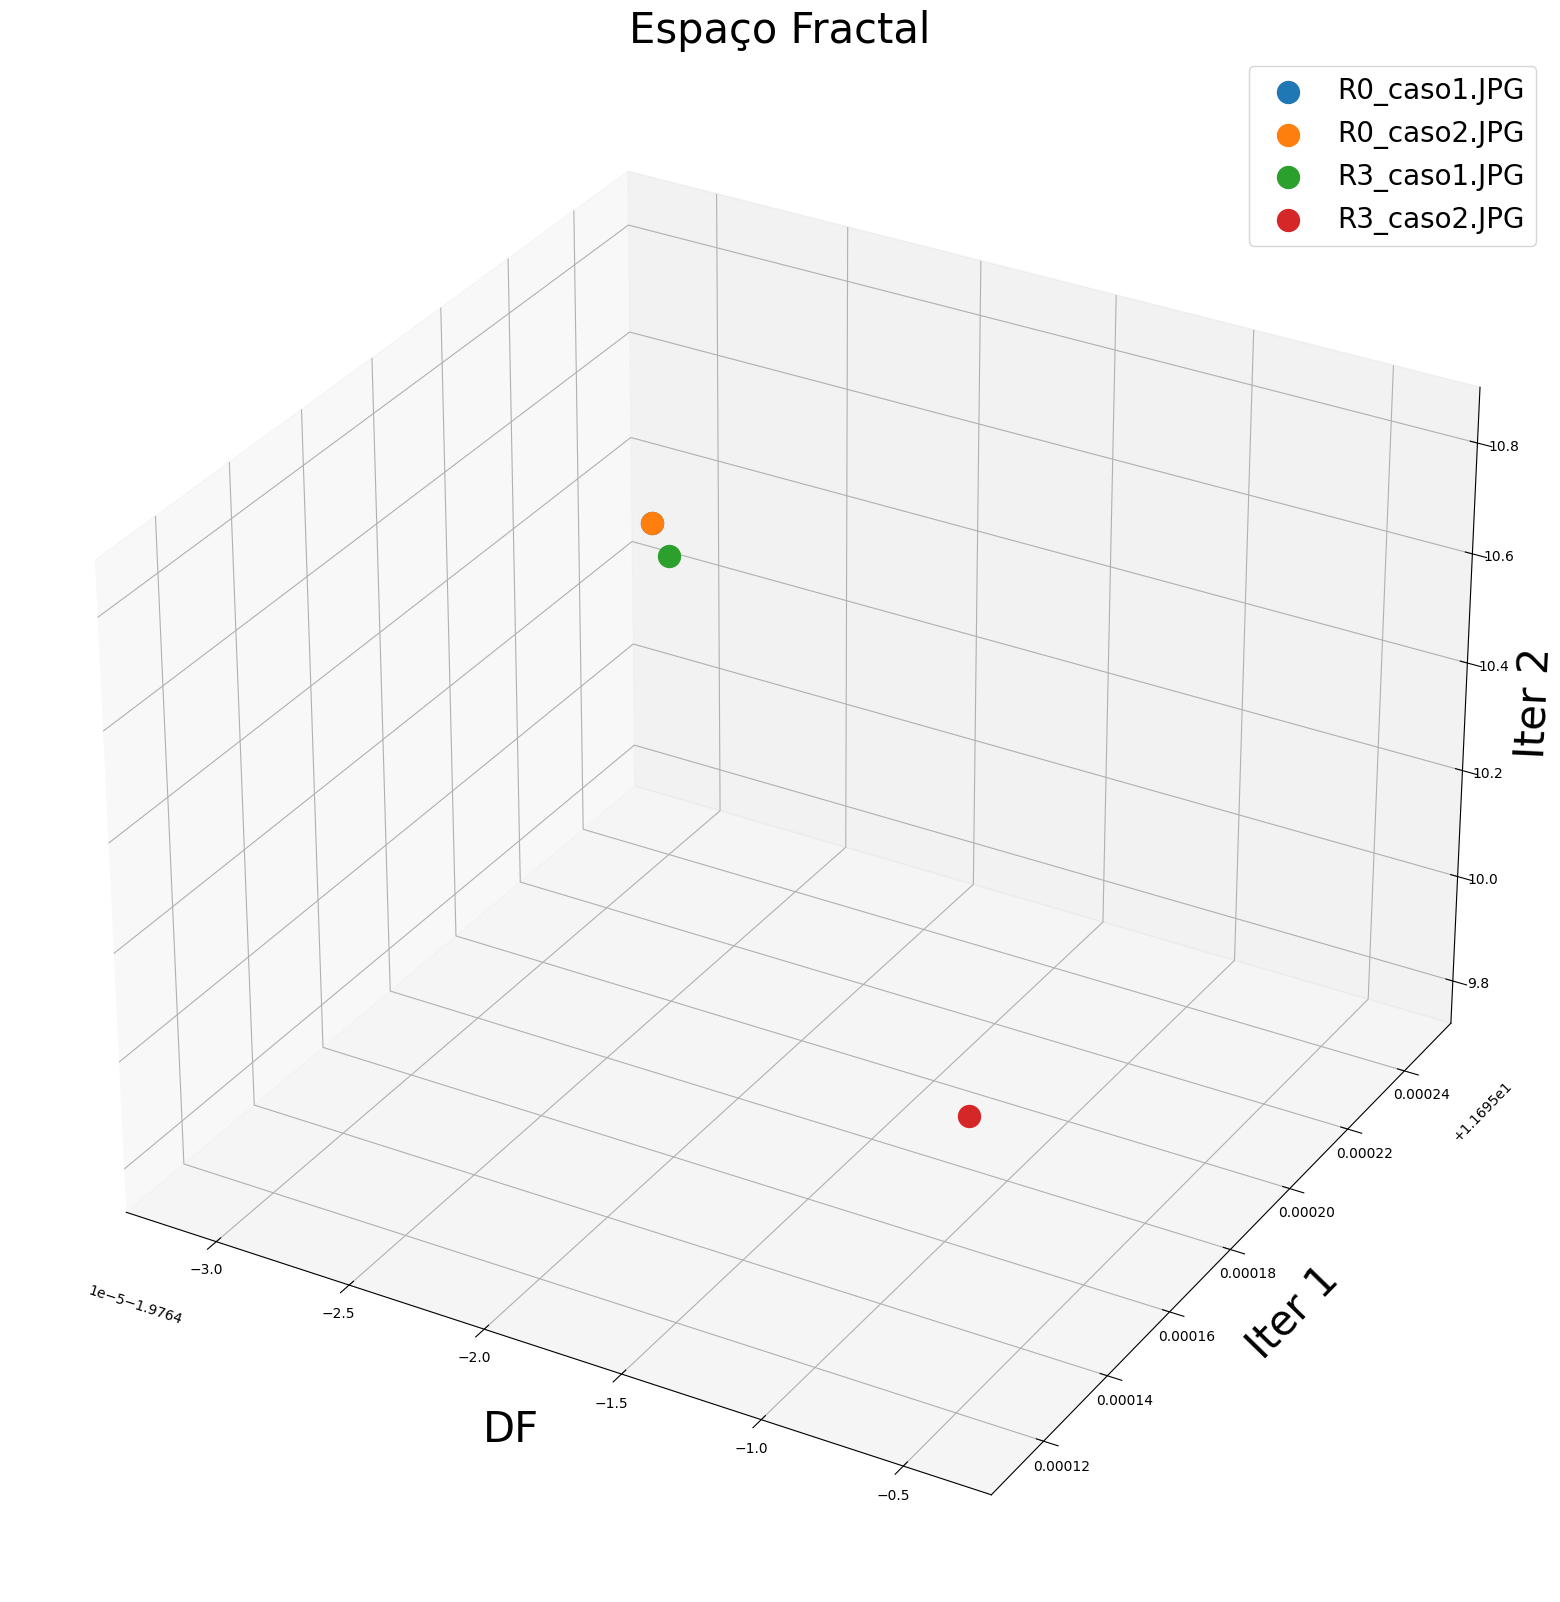

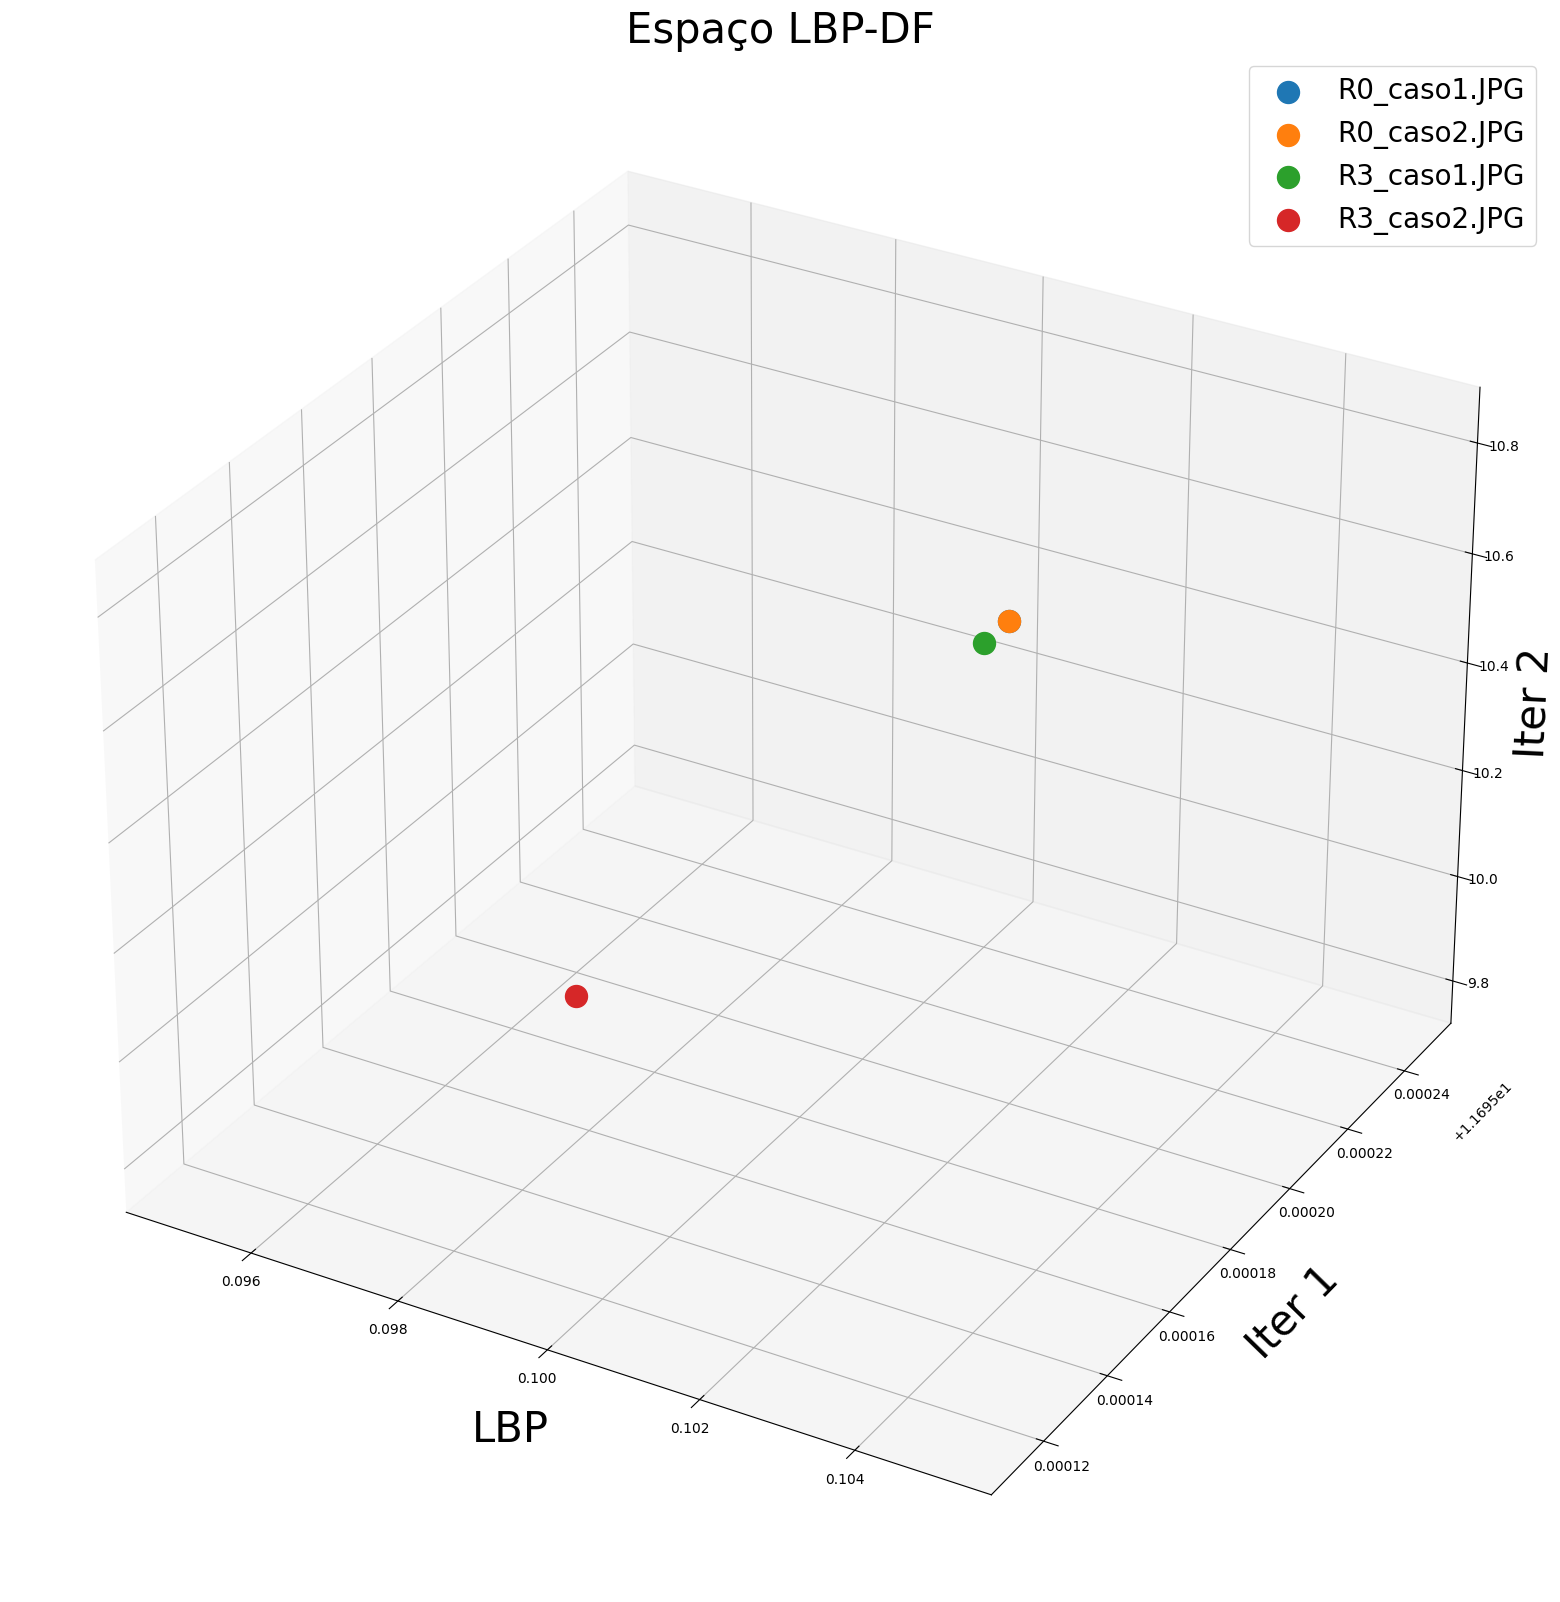

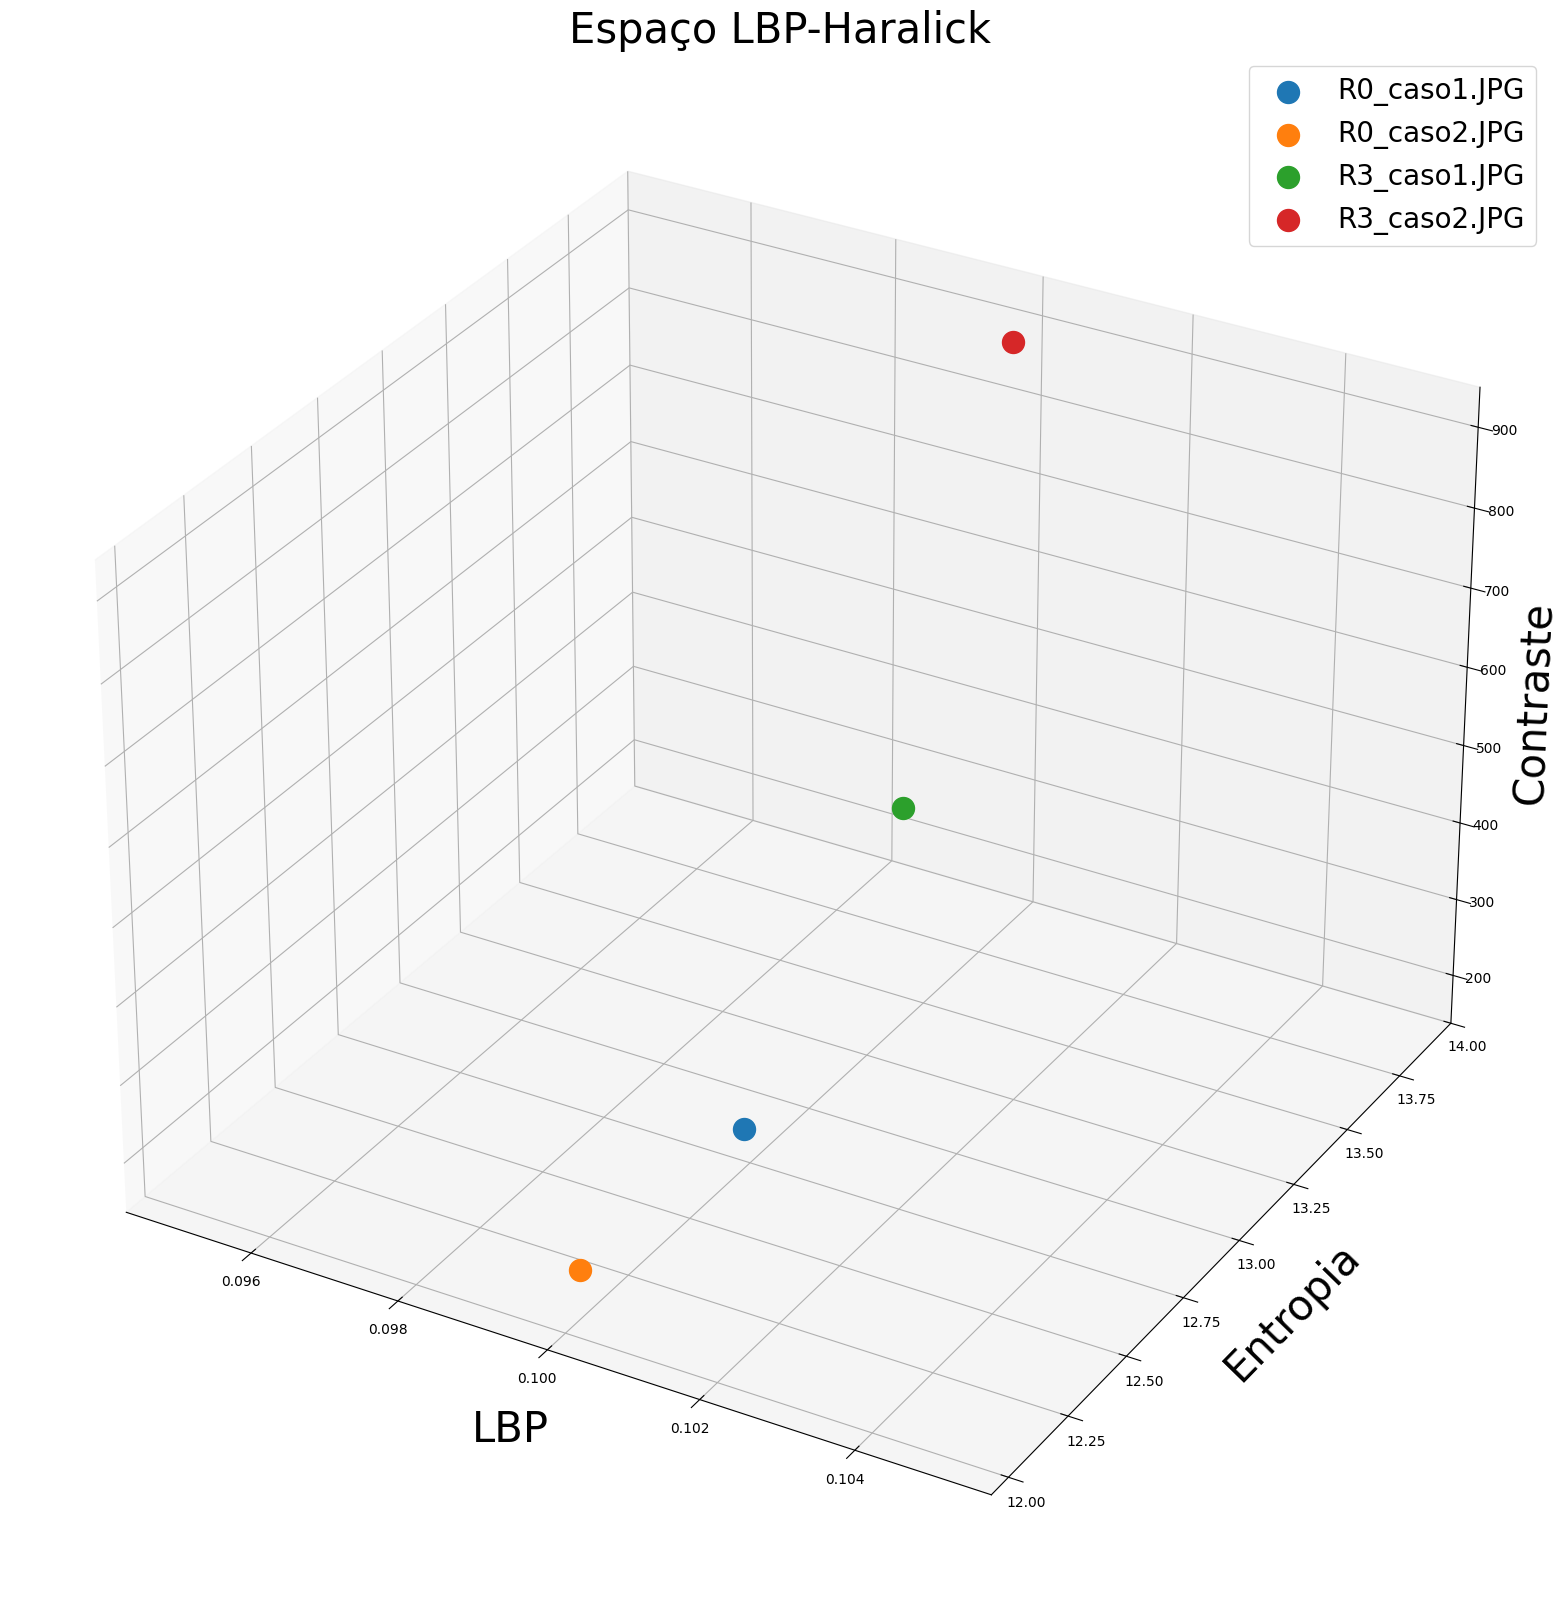

In [15]:
nomes, vetores = processar_diretorio("./Imagens/")
plotar_3d(vetores, nomes, indices=[0,1,2], titulo="Espaço Haralick", eixos=["ASM", "Entropia", "Contraste"])
plotar_3d(vetores, nomes, indices=[4,5,6], titulo="Espaço Fractal", eixos=["DF", "Iter 1", "Iter 2"])
plotar_3d(vetores, nomes, indices=[3,5,6], titulo="Espaço LBP-DF", eixos=["LBP", "Iter 1", "Iter 2"])
plotar_3d(vetores, nomes, indices=[3,1,2], titulo="Espaço LBP-Haralick", eixos=["LBP", "Entropia", "Contraste"])